In [1]:
# ----------------------------
# 1. Enhanced Imports
# ----------------------------
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
# ----------------------------
# Add Missing DTW Imputation Functions
# ----------------------------
def find_gaps(x):
    """Identify sequences of zeros (missing values)"""
    x = pd.Series(x)
    missing_seqs = []
    in_gap = False
    start_idx = -1
    
    for i, val in enumerate(x):
        if not in_gap and val == 0:
            in_gap = True
            start_idx = i
        elif in_gap and val != 0:
            missing_seqs.append((start_idx, i))
            in_gap = False
            start_idx = -1
    return missing_seqs

def edtwbi(x, start_index, end_index):
    """Enhanced DTW-based imputation (simplified version)"""
    len_gap = end_index - start_index
    # For simplicity, use mean of surrounding values
    before = x[max(0, start_index-24):start_index]
    after = x[end_index:end_index+24]
    return np.mean(np.concatenate([before, after]))

def impute_dtwi(arr):
    """Main DTW imputation function"""
    arr = pd.Series(arr).fillna(0).values
    filled_arr = arr.copy()
    gaps = find_gaps(arr)
    
    for gap in gaps:
        if gap[1] - gap[0] < 0.3*len(arr):
            filled_arr[gap[0]:gap[1]] = edtwbi(arr, gap[0], gap[1])
    
    return filled_arr

# ----------------------------
# Updated safe_impute Function
# ----------------------------

# ----------------------------
# ALTERNATIVE: More Robust Version
# ----------------------------
def simple_impute(data):
    """Simple but effective imputation"""
    # Convert to pandas Series
    if isinstance(data, np.ndarray):
        series = pd.Series(data)
    else:
        series = data.copy()
    
    # Simple interpolation + forward/backward fill
    filled = series.interpolate().fillna(method='ffill').fillna(method='bfill')
    
    # If still NaN, use mean
    filled = filled.fillna(series.mean())
    
    return filled.values


# Load data
df = pd.read_csv('2016_THUWAL_data_wide.csv', parse_dates=['date'])

# 1. Impute core features using hybrid approach
for col in ['ws3m', 't2', 'rh2', 'wd3m']:
    df[col] = simple_impute(df[col].values)

# 2. Feature engineering with NaN-safe operations
def create_time_features(df):
    """Temporal features without NaNs"""
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    return df

def create_derived_features(df):
    """NaN-safe derived features"""
    # Wind speed changes (handle initial NaN)
    df['ws3m_diff'] = df['ws3m'].diff().fillna(0).abs()
    
    # Rolling stats with minimum periods
    df['ws3m_roll24_mean'] = df['ws3m'].rolling(24, min_periods=1).mean()
    df['ws3m_roll24_std'] = df['ws3m'].rolling(24, min_periods=1).std().fillna(0)
    
    
    return df

df = create_time_features(df)
df = create_derived_features(df)

# 3. Final check for remaining NaNs (should be zero)
assert df.isna().sum().sum() == 0, "NaN values still present!"


/var/folders/td/5fhnfwgx40zgv3m3hgn3n1040000gn/T/ipykernel_45802/1987775659.py:57: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled = series.interpolate().fillna(method='ffill').fillna(method='bfill')


In [3]:
df

,date,hour,lon,lat,dniuncer,ghiuncer,t2,wd3m,ws3m,swddhi,swddni,ghi,rh2,sfcpres,dhiuncer,day_of_year,week_of_year,ws3m_diff,ws3m_roll24_mean,ws3m_roll24_std
0,2016-01-01,0,39.1,22.3,0.0,0.0,19.6,37.0,2.1,0.0,0.0,0.0,69.6,1013.2,0.0,1,53,0.0,2.100000,0.000000
1,2016-01-01,1,39.1,22.3,0.0,0.0,18.9,39.0,1.7,0.0,0.0,0.0,69.6,1013.0,0.0,1,53,0.4,1.900000,0.282843
2,2016-01-01,2,39.1,22.3,0.0,0.0,18.6,45.0,1.5,0.0,0.0,0.0,70.3,1013.0,0.0,1,53,0.2,1.766667,0.305505
3,2016-01-01,3,39.1,22.3,0.0,0.0,18.5,37.0,2.1,0.0,0.0,0.0,69.0,1012.7,0.0,1,53,0.6,1.850000,0.300000
4,2016-01-01,4,39.1,22.3,0.0,0.0,18.0,55.0,1.9,0.0,0.0,0.0,69.6,1012.5,0.0,1,53,0.2,1.860000,0.260768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2016-12-31,19,39.1,22.3,0.0,0.0,24.0,313.0,2.3,0.0,0.0,0.0,80.1,1013.9,0.0,366,52,0.3,2.479167,0.541318
8780,2016-12-31,20,39.1,22.3,0.0,0.0,23.9,316.0,2.3,0.0,0.0,0.0,81.7,1014.2,0.0,366,52,0.0,2.416667,0.463134
8781,2016-12-31,21,39.1,22.3,0.0,0.0,23.9,321.0,2.0,0.0,0.0,0.0,83.3,1014.6,0.0,366,52,0.3,2.404167,0.470411
8782,2016-12-31,22,39.1,22.3,0.0,0.0,23.9,338.0,2.0,0.0,0.0,0.0,83.1,1014.7,0.0,366,52,0.0,2.425000,0.438624


In [4]:
features = [
    'ws3m', 't2', 'rh2', 'wd3m',  # Original features
    'hour','day_of_year',               # Temporal features                 # Rate of change
    'ws3m_roll24_mean', 'ws3m_roll24_std'  # Rolling statistics
]
target_col = 0  # ws3m is first feature


In [33]:
# ----------------------------
# 3. Core Pipeline (Enhanced)
# ----------------------------
def create_features(data, n_steps=24, forecast_horizon=12):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_horizon + 1):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps+forecast_horizon-1, target_col])
    return np.array(X), np.array(y)

def split_data(data, train_ratio=0.6):
    train_len = int(len(data) * train_ratio)
    val_len = (len(data) - train_len) // 2
    return (
        data[:train_len],
        data[train_len:train_len+val_len],
        data[train_len+val_len:]
    )


In [35]:
# Split -> Scale -> Feature creation
raw_data = df[features].values
train_raw, val_raw, test_raw = split_data(raw_data)

scaler = StandardScaler()
train_data = scaler.fit_transform(train_raw).astype(np.float32)
val_data = scaler.transform(val_raw).astype(np.float32)
test_data = scaler.transform(test_raw).astype(np.float32)

window_size = 24
X_train, y_train = create_features(train_data, window_size)
X_val, y_val = create_features(val_data, window_size)
X_test, y_test = create_features(test_data, window_size)


In [37]:
# ----------------------------
# 4. Enhanced Model Architecture
# ----------------------------
class EnhancedBPNN(nn.Module):
    def __init__(self, input_size, hidden_size=400, output_size=1):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),  # Added dropout
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, output_size)
        )
        
    def forward(self, x):
        return self.net(self.flatten(x))


In [39]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedBPNN(
    input_size=window_size * len(features),  # 5*8=40
    hidden_size=400,
    output_size=1
).to(device)


In [41]:
# ----------------------------
# 5. Enhanced Training Protocol
# ----------------------------
criterion = nn.HuberLoss()  # Better for extremes
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)


In [43]:
# Convert to datasets
class WindDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = WindDataset(X_train, y_train)
val_dataset = WindDataset(X_val, y_val)


In [45]:
# DataLoaders
batch_size = 64  # Increased from 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop
train_losses = []
valid_losses = []
NUM_EPOCHS = 500  # Increased from 200


In [47]:
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            val_loss += criterion(outputs, labels).item()
    
    # Record metrics
    train_losses.append(train_loss/len(train_loader))
    valid_losses.append(val_loss/len(val_loader))
    
    print(f'Epoch {epoch+1:3} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {valid_losses[-1]:.4f}')


Epoch   1 | Train Loss: 0.2214 | Val Loss: 0.1366
Epoch   2 | Train Loss: 0.1855 | Val Loss: 0.1453
Epoch   3 | Train Loss: 0.1747 | Val Loss: 0.1503
Epoch   4 | Train Loss: 0.1713 | Val Loss: 0.1613
Epoch   5 | Train Loss: 0.1634 | Val Loss: 0.1510
Epoch   6 | Train Loss: 0.1591 | Val Loss: 0.1557
Epoch   7 | Train Loss: 0.1534 | Val Loss: 0.1691
Epoch   8 | Train Loss: 0.1455 | Val Loss: 0.1672
Epoch   9 | Train Loss: 0.1396 | Val Loss: 0.2513
Epoch  10 | Train Loss: 0.1358 | Val Loss: 0.1946
Epoch  11 | Train Loss: 0.1326 | Val Loss: 0.1875
Epoch  12 | Train Loss: 0.1271 | Val Loss: 0.1656
Epoch  13 | Train Loss: 0.1241 | Val Loss: 0.2577
Epoch  14 | Train Loss: 0.1161 | Val Loss: 0.1800
Epoch  15 | Train Loss: 0.1123 | Val Loss: 0.1719
Epoch  16 | Train Loss: 0.1109 | Val Loss: 0.2480
Epoch  17 | Train Loss: 0.1075 | Val Loss: 0.1684
Epoch  18 | Train Loss: 0.1047 | Val Loss: 0.2307
Epoch  19 | Train Loss: 0.0999 | Val Loss: 0.1591
Epoch  20 | Train Loss: 0.0958 | Val Loss: 0.1958


In [49]:
# ----------------------------
# 6. Enhanced Evaluation
# ----------------------------
# Test evaluation
test_dataset = WindDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

predictions = []
actuals = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy().flatten()
        predictions.extend(outputs)
        actuals.extend(labels.numpy())

# Inverse transform
scaler_mean = scaler.mean_[target_col]
scaler_scale = scaler.scale_[target_col]
predictions_orig = (np.array(predictions) * scaler_scale) + scaler_mean
actuals_orig = (np.array(actuals) * scaler_scale) + scaler_mean


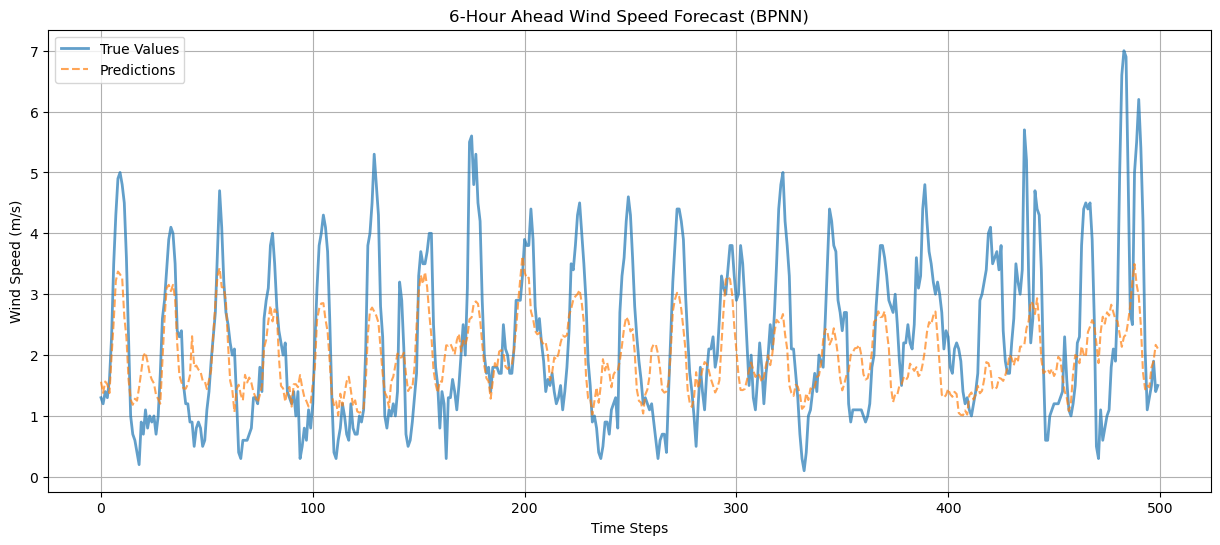

In [51]:
plt.figure(figsize=(15, 6))
plt.plot(actuals_orig[:500], label='True Values', alpha=0.7, linewidth=2)
plt.plot(predictions_orig[:500], label='Predictions', alpha=0.7, linestyle='--')
plt.title('6-Hour Ahead Wind Speed Forecast (BPNN)')
plt.ylabel('Wind Speed (m/s)')
plt.xlabel('Time Steps')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
print(f'MAE: {mean_absolute_error(actuals_orig, predictions_orig):.4f} m/s')
print(f'RMSE: {np.sqrt(mean_squared_error(actuals_orig, predictions_orig)):.4f} m/s')
print(f'MSE: {mean_squared_error(actuals_orig, predictions_orig):.4f} (m/s)²')

MAE: 1.0065 m/s
RMSE: 1.2570 m/s
MSE: 1.5800 (m/s)²
